# Summary information for statistics consulation

## Background

The field of information retrieval is concerned in part with the question:  given a collection $C$ of documents and query $Q$, what is the probability that a document $D$ is relevant to the query $Q$?  I generally work in the statistical language modeling framework and with the Kullback-Liebler (KL) divergence retrieval model specifically.  Under this model we estimate the query language model $p(w \vert \theta_Q)$ and the document language model $p(w \vert \theta_D)$ (both commonly modeled as multinomials) and score (or rank) all documents w.r.t. a query using the negative KL-divergence between the two distributions:

#### KL-divergence retrieval model

$score(Q,D) = -D (\theta_Q \vert \vert \theta_D) \sim \sum_{w \in V} p(w \vert \theta_Q) \log p(w \vert \theta_D)$

In the simplest form, we estimate the document language model $\theta_D$ using a smoothed language model. For example:

$p_{\lambda}(w \vert D) = (1 - \lambda) \dfrac{c(w, D)}{\vert D \vert} + \lambda p(w \vert C)$

Where $c(w,D)$ is the frequency of term $w$ in document $D$ and $p(w \vert C)$ is the collection language model (i.e., language model estimated over all of the words in a collection of documents).

In the absense of any additional information, the query language model is typically estimated using the MLE.

$p(w,Q) = \dfrac{c(w,Q)}{\vert Q \vert}$

#### Inverse document frequency

In information retrieval theory, another core concept (independent of language models) is the "inverse document frequency" (IDF):

$idf = \log \dfrac{N}{df}$

Where $N$ is the total number of documents in the corpus $C$ and $df$ is the number of documents containing the term $w$. IDF is seen as a measure of how much information a term provides.  The more documents that contain the term, the less useful it is for discriminating documents.

## Temporal information

The temporal information available in the distribution of terms in the collection is an area that hasn't been widely explored.  My research currently looks at whether the temporal distribution of terms in the collection or in the set of documents returned w.r.t. a query can be used to improve retrieval effectiveness.  One area that has proven promising is the use of term timeseries autocorrelation properties.

I expect there is a sort of "temporal IDF" that can be used to discrimate terms that have more temporal information than the collection.

## Examples

In this section I work through some motivation examples from two different test collections: the Associated Press news articles covering the years 1988-1989 and a small sample from the Twitter corpus from 2011.

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from matplotlib import pyplot
from math import log
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Example 1: Associated Press 1988-1989

In this example, read a file containing the daily frequencies of a subset of terms in a collection of Associated Press news articles from 1988-1989. The sum of all term frequencies for is stored in the column `_total_`:

In [2]:
df = pd.read_csv("data/ap.pruned.csv", header=None )
ts = df.transpose()
ts.columns = ts.iloc[0]
ts= ts.drop(ts.index[0])
ts.index = pd.DatetimeIndex(freq="d", start="1/12/1988", periods=689)
ts.head(5)

,1986,1988,_total_,abuse,accusations,acid,acquisition,across,actions,activities,...,waste,weapons,weather,welfare,what,which,why,wing,writers,young
1988-01-12,61,19,83126,5,1,1,1,21,3,11,...,1,9,14,3,79,201,20,4,1,18
1988-01-13,49,26,93742,4,4,0,0,35,3,7,...,1,28,9,0,100,216,26,2,2,23
1988-01-14,25,7,52991,1,0,0,0,25,0,8,...,1,9,3,3,70,119,8,3,1,19
1988-01-15,45,22,114264,6,3,16,1,40,7,10,...,1,48,11,6,117,219,19,8,20,43
1988-01-16,63,17,101941,2,1,0,0,33,2,9,...,1,52,9,1,101,205,9,5,4,37


Below is the unsmoothed temporal distribution of total term frequencies during the collection timeframe:

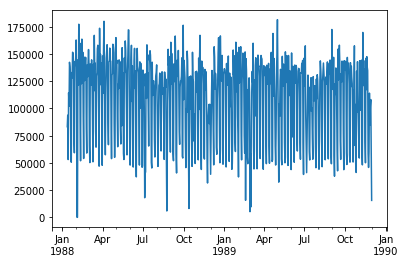

In [3]:
total = ts["_total_"].astype(int)
p = total.plot()

Next, plotting the sample autocorrelation for the AP collection we can see a clear period of 7 days.  This makes sense as newspapers have a weekly cycle (i.e., more articles are published on some days than others). 

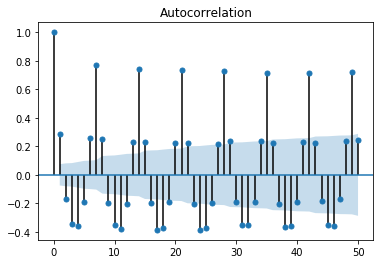

In [4]:
acfplt = plot_acf(total.dropna(), lags=50)

This particular collection covers the time period from 1988-1990, which includes the Exxon Valdex oil spill in March 1989.  We can now look at the sample distribution of the term "spill" during the collection timeframe:

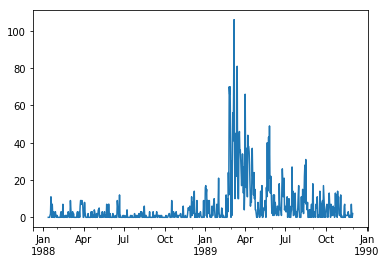

In [5]:
spill = ts["spill"].astype(int)
spill.plot()

And the sample autocorrelation of the term `spill`:

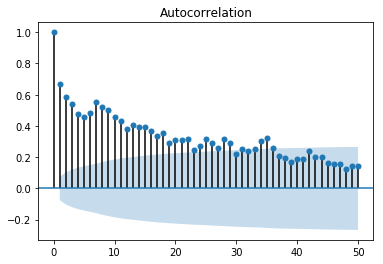

In [6]:
acf = plot_acf(spill.dropna(), lags=50)

Naively, comparing the sample autocorrelation of `spill` to the collection sample autocorrelation suggests a difference in temporal structure. This is further suggested by plots of a more common word (or stopword) such as `which`:

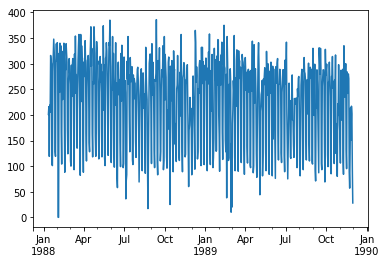

In [7]:
which = ts["which"].astype(int)
p = which.plot()

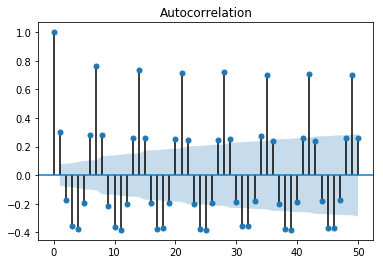

In [8]:
acf = plot_acf(which.dropna(), lags=50)

The ACF distribution is similar to the general collection distribution (i.e., ACF for `_total_`).

### Example 2: Twitter 
Below is a similar analysis of another corpus with different characteristics -- a small sample of Twitter from January 2011.

In [9]:
df = pd.read_csv("data/tweets2011.pruned.csv", header=None )
ts = df.transpose()
ts.columns = ts.iloc[0]
ts= ts.drop(ts.index[0])
ts.index = pd.DatetimeIndex(freq="h", start="1/23/2011", periods=409)
ts.head(5)

,2012,2022,_total_,aguilera,aid,airport,amtrak,anti,approval,aristide,...,week,weight,whisperer,white,william,winfrey,world,worm,yeates,yemen
2011-01-23 00:00:00,7,0,317889,0,9,11,0,6,4,0,...,74,16,0,46,2,0,93,2,3,0
2011-01-23 01:00:00,5,0,319962,0,4,10,0,10,1,0,...,54,17,0,36,5,2,61,1,0,0
2011-01-23 02:00:00,7,0,322628,2,6,8,0,11,2,0,...,59,12,0,29,2,1,87,1,0,0
2011-01-23 03:00:00,6,0,311223,0,6,4,0,11,2,0,...,48,18,0,39,3,2,78,0,0,1
2011-01-23 04:00:00,9,0,293359,0,6,6,0,5,0,0,...,54,16,0,31,6,0,96,1,0,0


Below is the unsmoothed temporal distribution of total term frequencies during the collection timeframe:

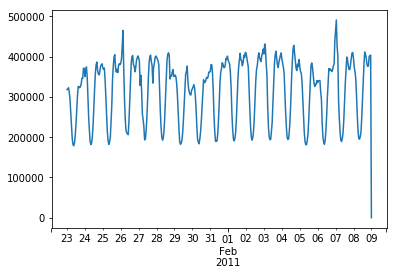

In [10]:
total = ts["_total_"].astype(int)
total.plot()

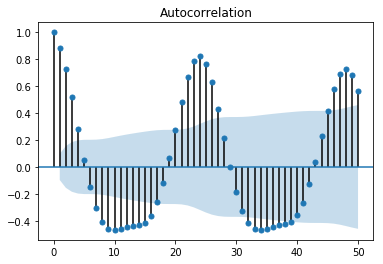

In [11]:
acfplt = plot_acf(total.dropna(), lags=50)

Compared to the AP example above, the Twitter corpus has an apparent 24 hour period.  Below is a sample term `sheen` that has a distinct sample autocorrelation. This refers to the actor Charlie Sheen's entry into a recovery program:

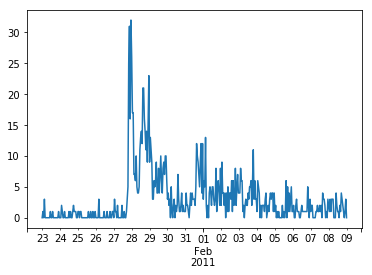

In [12]:
sheen = ts["sheen"].astype(int)
sheen.plot()

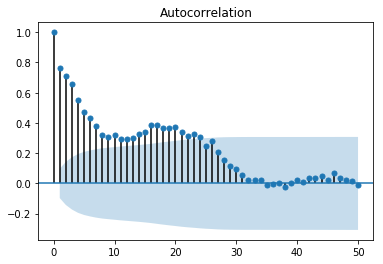

In [13]:
acfplt = plot_acf(sheen, lags=50)

## Questions for statistics consultation

The basic idea I'm pursuing is a measure of "temporal structure" or "temporal information" that can be derived from the time series distributions. The end goal will be to ultimately weight those query terms that have more temporal information or structure to improve retrieval effectiveness.

My initial experiments have used the sample timeseries autocorrelation and are promising but limited. My hope is to identify other methods of measuring temporal information in the timeseries distributions. However, my understanding of timeseries analysis methods is limited.

My hope is to find a sort of temporal IDF that can be used to identify terms with more "temporal information" than can be found in the collection.

Potential points for discussion:
* Are there other measures of "temporal information" that I could be considering? I've explored the entropy of the temporal distribution and the self-mutual information, but neither of these have proven effective empirically.
* Should I be considering some sort of transformation on the data, either via smoothing or decomposition?  When I've experimented with decomposition, I seem to lose useful information.
* I've focused on linear methods, but maybe non-linear methods are more appropriate for this data?
* Is it important that the collection and term models are related -- i.e., that the individual terms contribute to the collection model?